In [1]:
# PEP8-friendly imports groupés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

import joblib


In [2]:
# Version business (brute, non standardisée) pour l’interprétation des clusters
rfm_business = pd.read_csv("olist_customers_features.csv", index_col=0)

# Version standardisée pour le ML (entrée des algos)
X_scaled = pd.read_csv("olist_customers_features_scaled.csv", index_col=0)
X = X_scaled.values

In [11]:
display(rfm_business.head())
display(X_scaled.describe())
print("Shape:", X_scaled.shape)

,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
customer_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,5.0,6.411227
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4.0,3.285590
0000f46a3911fa3c0805444483337064,538,1,86.22,3.0,25.731759
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,4.0,20.037083
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,5.0,13.141134


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
count,9.335800e+04,9.335800e+04,9.335800e+04,9.335800e+04,9.335800e+04
mean,-8.996139e-17,6.005037e-17,2.268062e-17,-4.688343e-17,-5.327662e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.556524e+00,-1.598294e-01,-7.299499e-01,-2.471486e+00,-1.260677e+00
25%,-8.094540e-01,-1.598294e-01,-4.513421e-01,-1.204085e-01,-6.054050e-01
50%,-1.213630e-01,-1.598294e-01,-2.537064e-01,6.632840e-01,-2.443708e-01
75%,7.108993e-01,-1.598294e-01,7.671019e-02,6.632840e-01,3.299748e-01
max,3.115941e+00,6.679496e+01,5.964701e+01,6.632840e-01,2.064395e+01


Shape: (93358, 5)


Shape complet : (93358, 5)


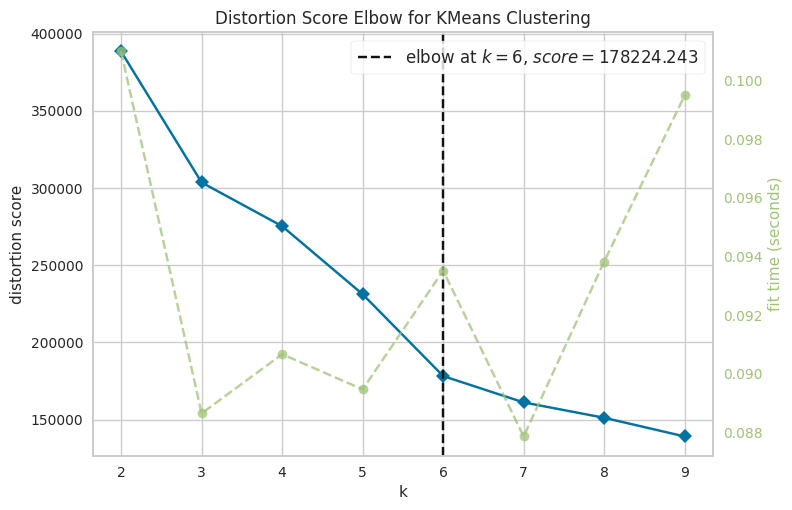

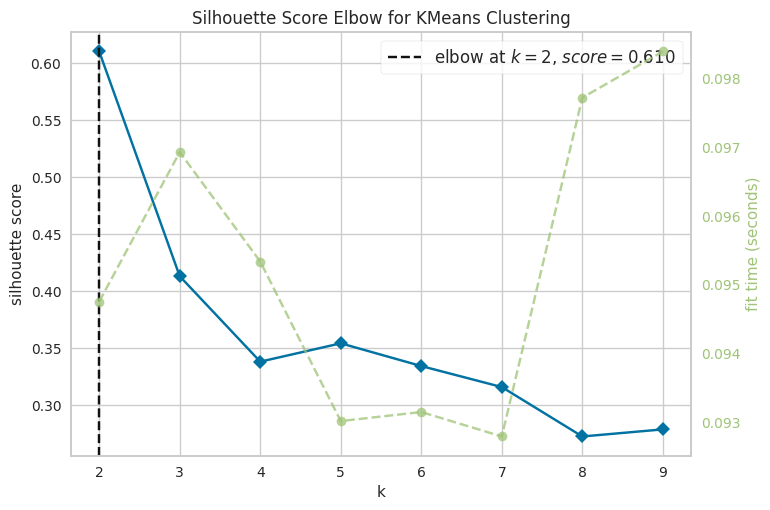

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [6]:
print("Shape complet :", X.shape)


# --- Elbow method (distortion / inertia) ---
model = KMeans(random_state=42, n_init="auto")
elbow_dist = KElbowVisualizer(model, k=(2, 10), metric="distortion")
elbow_dist.fit(X)
elbow_dist.show()

# --- Silhouette method ---
model = KMeans(random_state=42, n_init="auto")
elbow_sil = KElbowVisualizer(model, k=(2, 10), metric="silhouette")
elbow_sil.fit(X)
elbow_sil.show()


,k,inertia,silhouette,calinski_harabasz,davies_bouldin,min_cluster_size,max_cluster_size
0,2,380369,0.384,21211,1.420,16504,76854
1,3,303564,0.413,25098,1.110,2808,74668
2,4,246415,0.309,27830,1.074,2807,42925
3,5,203130,0.326,30293,0.978,2009,42050
4,6,178224,0.334,30230,0.986,1959,40278
5,7,161169,0.315,29503,0.997,1866,31893
6,8,148875,0.319,28478,0.970,419,31286
7,9,139115,0.279,27485,0.994,412,25694
8,10,129643,0.281,26973,0.987,227,25668


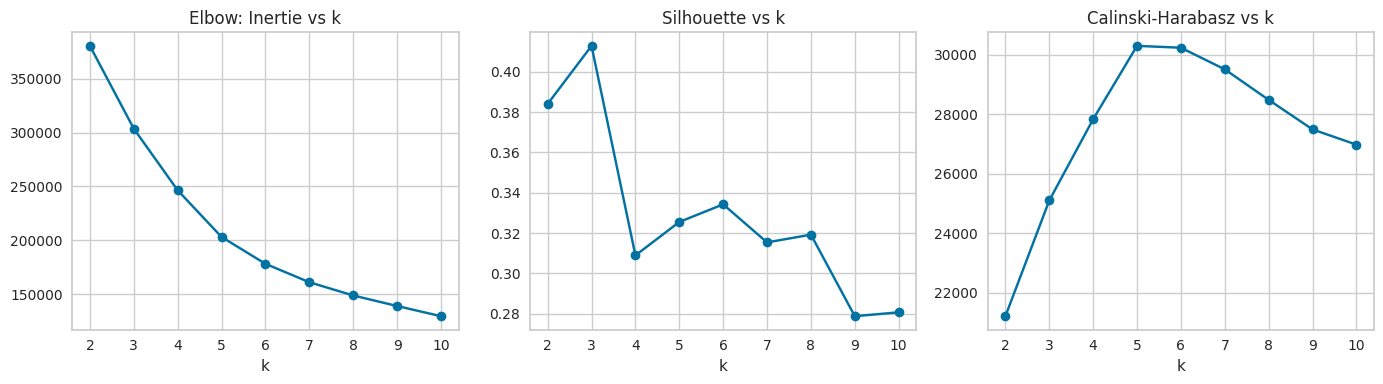

In [7]:
rows = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertia = km.inertia_
    sil = silhouette_score(X, labels, random_state=42)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    sizes = np.bincount(labels)
    rows.append({
        "k": k, "inertia": inertia, "silhouette": sil,
        "calinski_harabasz": ch, "davies_bouldin": db,
        "min_cluster_size": sizes.min(), "max_cluster_size": sizes.max()
    })

scores = pd.DataFrame(rows)
display(scores.style.format({"inertia":"{:.0f}", "silhouette":"{:.3f}", "calinski_harabasz":"{:.0f}", "davies_bouldin":"{:.3f}"}))

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(scores["k"], scores["inertia"], marker="o"); ax[0].set_title("Elbow: Inertie vs k"); ax[0].set_xlabel("k")
ax[1].plot(scores["k"], scores["silhouette"], marker="o"); ax[1].set_title("Silhouette vs k"); ax[1].set_xlabel("k")
ax[2].plot(scores["k"], scores["calinski_harabasz"], marker="o"); ax[2].set_title("Calinski-Harabasz vs k"); ax[2].set_xlabel("k")
plt.tight_layout(); plt.show()

In [8]:
def describe_clusters(labels, df_business, cols=None):
    out = df_business.copy()
    out["cluster"] = labels
    if cols is None:
        cols = ["recency_days","frequency","monetary","avg_review_score","avg_delivery_delay"]
    desc = out.groupby("cluster")[cols].mean().round(2)
    sizes = out["cluster"].value_counts().sort_index()
    return desc, sizes

# k=3
km3 = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X)
desc3, sizes3 = describe_clusters(km3.labels_, rfm_business)
print("K=3 — silhouette:", silhouette_score(X, km3.labels_))
display(sizes3.to_frame("count")); display(desc3)

# k=4
km4 = KMeans(n_clusters=4, random_state=42, n_init=20).fit(X)
desc4, sizes4 = describe_clusters(km4.labels_, rfm_business)
print("K=4 — silhouette:", silhouette_score(X, km4.labels_))
display(sizes4.to_frame("count")); display(desc4)

# k=5
km5 = KMeans(n_clusters=5, random_state=42, n_init=20).fit(X)
desc5, sizes5 = describe_clusters(km5.labels_, rfm_business)
print("K=5 — silhouette:", silhouette_score(X, km5.labels_))
display(sizes5.to_frame("count")); display(desc5)

# k=6
km6 = KMeans(n_clusters=6, random_state=42, n_init=20).fit(X)
desc6, sizes6 = describe_clusters(km6.labels_, rfm_business)
print("K=6 — silhouette:", silhouette_score(X, km6.labels_))
display(sizes6.to_frame("count")); display(desc6)

K=3 — silhouette: 0.4129621802989263


,count
cluster,
0,74668
1,2808
2,15882


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,237.58,1.00,153.00,4.65,10.60
1,220.85,2.11,325.88,4.20,12.34
2,246.07,1.00,194.14,1.79,21.87


K=4 — silhouette: 0.3088924981769639


,count
cluster,
0,33265
1,42925
2,14361
3,2807


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,390.99,1.00,155.96,4.59,11.73
1,123.27,1.00,152.23,4.64,9.94
2,233.26,1.00,194.23,1.66,22.41
3,220.92,2.11,324.39,4.20,12.35


K=5 — silhouette: 0.32550165456093455


,count
cluster,
0,14011
1,2772
2,32516
3,2009
4,42050


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,233.26,1.00,157.01,1.66,22.40
1,221.00,2.11,289.68,4.21,12.33
2,391.17,1.00,134.23,4.59,11.69
3,235.93,1.02,1252.73,4.11,14.06
4,123.51,1.00,131.71,4.64,9.92


K=6 — silhouette: 0.3342499121929497


,count
cluster,
0,31318
1,40278
2,5097
3,2770
4,11936
5,1959


,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,393.06,1.00,134.51,4.65,11.60
1,122.19,1.00,131.79,4.71,9.90
2,240.84,1.00,170.76,2.09,39.23
3,221.03,2.11,289.76,4.21,12.29
4,229.19,1.00,147.12,1.84,12.64
5,235.25,1.02,1262.09,4.14,13.53


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_silhouette(X, labels, n_clusters, title="Silhouette plot"):
    """
    X : features (déjà standardisées)
    labels : labels de clustering (array 1D)
    n_clusters : nombre de clusters (int)
    """
    sil_vals = silhouette_samples(X, labels)
    avg_sil = silhouette_score(X, labels)

    fig, ax = plt.subplots(figsize=(8, 5))

    y_lower = 10
    for cluster in range(n_clusters):
        cluster_sil_vals = sil_vals[labels == cluster]
        cluster_sil_vals.sort()

        size_cluster = cluster_sil_vals.shape[0]
        y_upper = y_lower + size_cluster

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil_vals,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    ax.axvline(x=avg_sil, color="red", linestyle="--", label=f"Silhouette moyenne = {avg_sil:.3f}")
    ax.set_xlabel("Coefficient de silhouette")
    ax.set_ylabel("Cluster")
    ax.set_title(title)
    ax.legend(loc="best")
    ax.set_xlim([-0.2, 1])
    plt.tight_layout()
    plt.show()


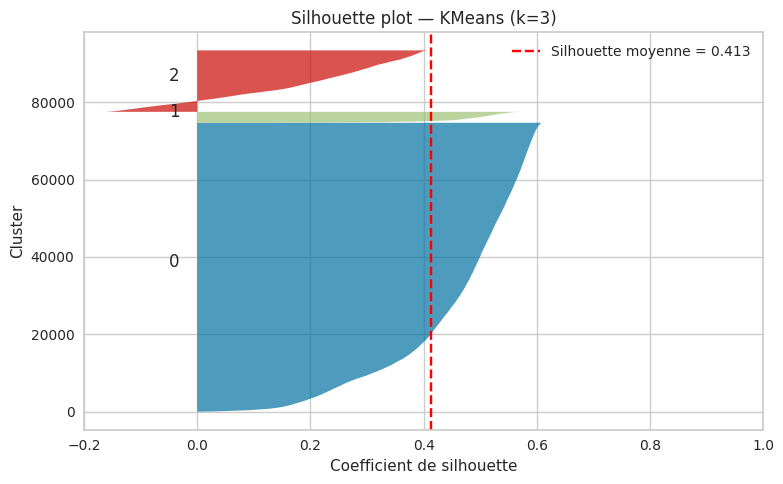

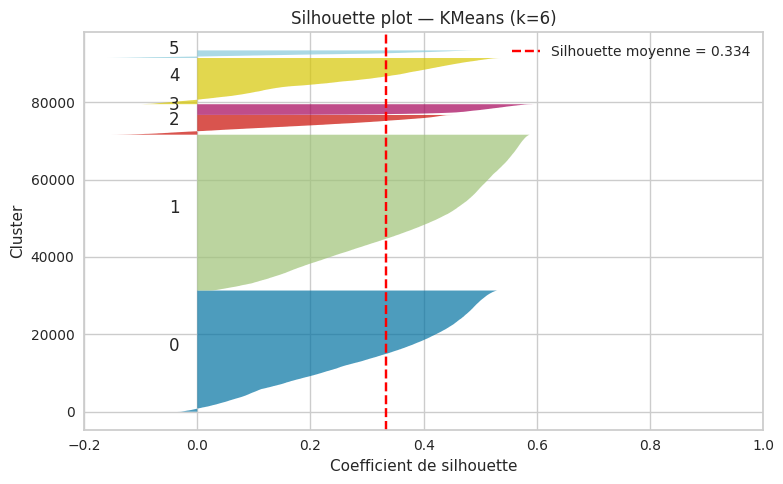

In [7]:
# Comparaison des silhouettes pour k=3 et k=6
labels_k3 = km3.labels_  

plot_silhouette(
    X_scaled,
    labels_k3,
    n_clusters=3,
    title="Silhouette plot — KMeans (k=3)"
)

labels_k6 = km6.labels_  # ou km6.predict(X_scaled)

plot_silhouette(
    X_scaled,
    labels_k6,
    n_clusters=6,
    title="Silhouette plot — KMeans (k=6)"
)

Mathématiquement, k=3 est la segmentation la plus cohérente : la silhouette moyenne est nettement meilleure et les clusters sont plus compacts et bien séparés. Toutefois, dans une logique marketing, une segmentation trop grossière limite l’actionnabilité : un cluster représente une grande majorité des clients, ce qui n’est pas exploitable pour concevoir des stratégies ciblées.

En augmentant à k=6, on perd un peu en cohérence statistique, mais on gagne une finesse de segmentation réellement utile pour le métier. Ce choix s’inscrit également dans la continuité d’une segmentation historique déjà basée sur 6 groupes. Ainsi, k=6 constitue un compromis équilibré entre qualité mathématique et pertinence opérationnelle.

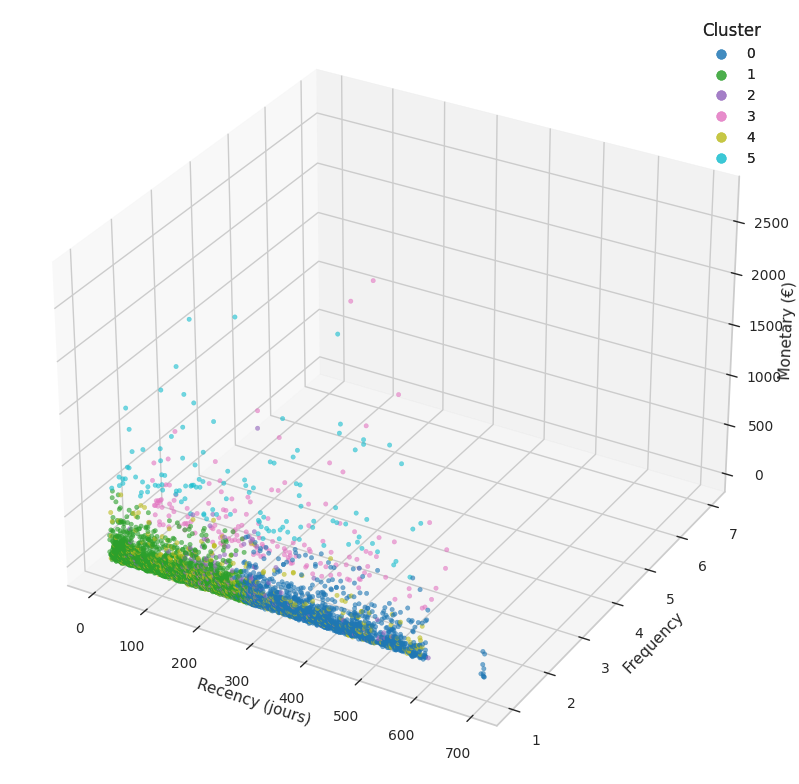

In [9]:
rfmk6=pd.read_csv("olist_customers_segments_k6.csv", index_col=0)
cols = ["recency_days", "frequency", "monetary"]
X_rfm = rfmk6[cols].values
labels_k6 = rfmk6["cluster"].values

# Sous-échantillon pour la visu
max_points = 5000
rng = np.random.RandomState(42)
idx = rng.choice(len(X_rfm), size=min(max_points, len(X_rfm)), replace=False)

X_sub = X_rfm[idx]
lab_sub = labels_k6[idx]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    X_sub[:, 0],  # Recency
    X_sub[:, 1],  # Frequency
    X_sub[:, 2],  # Monetary
    c=lab_sub,
    cmap="tab10",
    s=10,
    alpha=0.6,
)

ax.set_xlabel("Recency (jours)")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary (€)")

legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.tight_layout()
plt.show()


In [6]:
rfmk3 = pd.read_csv("olist_customers_segments_k3.csv", index_col=0)

# Option : log pour mieux voir
rfmk3["monetary_log"] = np.log1p(rfmk3["monetary"])

# Sous-échantillon pour la visu
max_points = 5000
rng = np.random.RandomState(42)
idx = rng.choice(len(rfmk3), size=min(max_points, len(rfmk3)), replace=False)

df_sub = rfmk3.iloc[idx]

fig = px.scatter_3d(
    df_sub,
    x="recency_days",
    y="frequency",
    z="monetary",  
    color="cluster",
    opacity=0.6,
    title="Clusters K=3 en 3D (R, F, M)",
)

fig.update_traces(marker=dict(size=3))
fig.show()


In [5]:
import numpy as np
import plotly.express as px

rfmk6 = pd.read_csv("olist_customers_segments_k6.csv", index_col=0)

# Option : log pour mieux voir
rfmk6["monetary_log"] = np.log1p(rfmk6["monetary"])

# Sous-échantillon pour la visu
max_points = 5000
rng = np.random.RandomState(42)
idx = rng.choice(len(rfmk6), size=min(max_points, len(rfmk6)), replace=False)

df_sub = rfmk6.iloc[idx]

fig = px.scatter_3d(
    df_sub,
    x="recency_days",
    y="frequency",
    z="monetary",  
    color="cluster",
    opacity=0.6,
    title="Clusters K=6 en 3D (R, F, M)",
)

fig.update_traces(marker=dict(size=3))
fig.show()


## Lecture des 6 clusters
Cluster 0 — Clients anciens, peu actifs mais satisfaits

Récence élevée : ~393 jours

Fréquence : 1 achat

Montant faible : 134 €

Review excellente : 4.6

Délai correct : 11.6 jours
➡️ Anciens clients satisfaits mais inactifs → bonne cible pour une campagne de réactivation.

Cluster 1 — Nouveaux clients satisfaits, faible dépense

Très récents : ~122 jours

Fréquence : 1 achat

Montant faible : 132 €

Reviews excellentes : 4.7

Délai rapide : 9.9 jours
➡️ Nouveaux clients contents mais encore peu engagés → idéal pour une stratégie de fidélisation.

Cluster 2 — One-shot très insatisfaits

Moyennement récents : ~241 jours

Fréquence : 1 achat

Montant modéré : 170 €

Review très mauvaise : 2.1

Délai catastrophique : 39 jours
➡️ Clients fortement insatisfaits (problème logistique visible) → très forte probabilité de churn, faible potentiel de récupération.

Cluster 3 — Clients réguliers à bon potentiel

Récence moyenne : ~221 jours

Fréquence élevée : 2.1 achats (le plus haut du dataset)

Montant moyen : 289 €

Review bonne : 4.2

Délai normal : 12.3 jours
➡️ Clients engagés, réguliers, bonne satisfaction → cœur de cible marketing, à maintenir et développer.

Cluster 4 — One-shot insatisfaits (impact modéré)

Récence moyenne : ~229 jours

Fréquence : 1

Montant faible : 147 €

Review mauvaise : 1.8

Délai médiocre : 12.6 jours
➡️ Insatisfaction modérée : délais un peu longs, mauvaise review, mais moins extrême que le cluster 2. → Segment “à surveiller / à corriger”.

Cluster 5 — Clients premium / gros acheteurs

Récence moyenne : ~235 jours

Fréquence : 1

Montant très élevé : 1262 € (ultra dominant dans le dataset)

Review correcte : 4.1

Délai moyen : 13.5 jours
➡️ Clients à très forte valeur, même si pas forcément récurrents → cibles pour VIP, cross-sell et bundles haut de gamme.

K=6 permet de distinguer :

des clients satisfaits mais inactifs (C0)

des nouveaux clients à fidéliser (C1)

deux types d’insatisfaction, modérée (C4) vs sévère (C2)

un groupe régulier / rentable (C3)

un groupe premium à très forte valeur (C5)

C’est une segmentation très exploitable par les équipes marketing :

réactivation (C0)

fidélisation (C1)

correction / service client (C2–C4)

développement (C3)

VIP (C5)

In [9]:
# ============================
# 1) Sous-échantillon commun
# ============================

max_samples = 10_000
rng = np.random.RandomState(42)

n_samples = min(max_samples, X.shape[0])
idx = rng.choice(X.shape[0], size=n_samples, replace=False)

X_sub = X[idx]

print("Shape sous-échantillon :", X_sub.shape)





Shape sous-échantillon : (10000, 5)


In [22]:
# ============================
# 2) Agglomerative Clustering
# ============================

sil_agglo = []
K_RANGE = [3, 4, 5, 6]
for k in K_RANGE:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels_agg = agg.fit_predict(X_sub)
    sil_agg = silhouette_score(X_sub, labels_agg)
    sil_agglo.append(silhouette_score(X_sub, labels_agg))
    print(f"Agglo Ward k={k} — silhouette={sil_agg:.3f}")


scores_agglo = pd.DataFrame({"k": K_RANGE, "silhouette": sil_agglo})

Agglo Ward k=3 — silhouette=0.436
Agglo Ward k=4 — silhouette=0.313
Agglo Ward k=5 — silhouette=0.311
Agglo Ward k=6 — silhouette=0.308


In [23]:
scores_agglo

,k,silhouette
0,3,0.436436
1,4,0.313109
2,5,0.311068
3,6,0.307927


In [ ]:
# ============================
# 3) DBSCAN
# ============================

eps_values = [0.3, 0.5, 0.7]
dbscan_rows = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X)

    # Répartition des labels
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))
    print(f"\nDBSCAN eps={eps}")
    print("Répartition des labels :", label_counts)

    # % de bruit
    noise_ratio = np.mean(labels == -1)

    # Silhouette sur les points non bruit (sinon pas défini)
    if len(set(labels)) > 1 and np.any(labels != -1):
        sil = silhouette_score(X[labels != -1], labels[labels != -1])
    else:
        sil = np.nan

    print(f"Silhouette DBSCAN: {sil:.3f}")

    dbscan_rows.append({
        "eps": eps,
        "silhouette": sil,
        "noise_ratio": noise_ratio,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0)
    })

dbscan_scores = pd.DataFrame(dbscan_rows)
display(dbscan_scores)




DBSCAN eps=0.3
Répartition des labels : {np.int64(-1): np.int64(3947), np.int64(0): np.int64(52077), np.int64(1): np.int64(17780), np.int64(2): np.int64(6980), np.int64(3): np.int64(8010), np.int64(4): np.int64(2404), np.int64(5): np.int64(7), np.int64(6): np.int64(1233), np.int64(7): np.int64(5), np.int64(8): np.int64(7), np.int64(9): np.int64(5), np.int64(10): np.int64(32), np.int64(11): np.int64(11), np.int64(12): np.int64(6), np.int64(13): np.int64(10), np.int64(14): np.int64(5), np.int64(15): np.int64(143), np.int64(16): np.int64(8), np.int64(17): np.int64(4), np.int64(18): np.int64(5), np.int64(19): np.int64(6), np.int64(20): np.int64(7), np.int64(21): np.int64(97), np.int64(22): np.int64(15), np.int64(23): np.int64(4), np.int64(24): np.int64(22), np.int64(25): np.int64(12), np.int64(26): np.int64(4), np.int64(27): np.int64(5), np.int64(28): np.int64(36), np.int64(29): np.int64(15), np.int64(30): np.int64(19), np.int64(31): np.int64(10), np.int64(32): np.int64(5), np.int64(33): 

,eps,silhouette,noise_ratio,n_clusters
0,0.3,-0.021105,0.042278,99
1,0.5,0.169259,0.015092,40
2,0.7,0.426351,0.007573,17


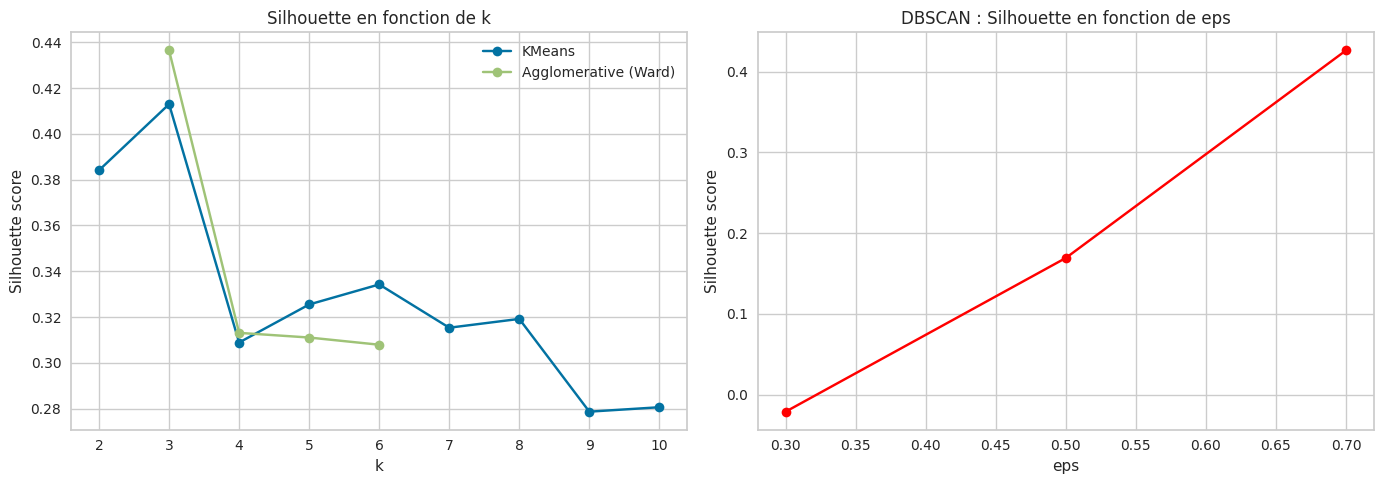

In [24]:
# --- Figure comparée ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1 : KMeans vs Agglo
axes[0].plot(scores["k"], scores["silhouette"], marker="o", label="KMeans")
axes[0].plot(scores_agglo["k"], scores_agglo["silhouette"], marker="o",
             label="Agglomerative (Ward)")
axes[0].set_title("Silhouette en fonction de k")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Silhouette score")
axes[0].grid(True)
axes[0].legend()

# Panel 2 : DBSCAN vs eps
axes[1].plot(dbscan_scores["eps"], dbscan_scores["silhouette"], marker="o", color="red")
axes[1].set_title("DBSCAN : Silhouette en fonction de eps")
axes[1].set_xlabel("eps")
axes[1].set_ylabel("Silhouette score")
axes[1].grid(True)

plt.tight_layout()
plt.show()


DBSCAN repose sur des zones de densité homogènes. Sur nos données RFM, l’espace est très continu, sans frontières naturelles, ce qui conduit DBSCAN à produire soit un très grand cluster et du bruit, soit des micro-clusters non interprétables. Pour preuve, même en ajustant eps de 0.3 à 0.7, le silhouette score reste extrêmement faible (entre -0.09 et 0.24), bien en dessous d’un clustering cohérent. DBSCAN n’est donc pas adapté à ces données.

In [13]:
# Modèle final (KMeans k=6)
seg = rfm_business.copy()
seg["cluster"] = km6.labels_

n_total = len(seg)

summary_k6 = (
    seg
    .groupby("cluster")
    .agg(
        count=("cluster", "size"),
        recency_days=("recency_days", "mean"),
        frequency=("frequency", "mean"),
        monetary=("monetary", "mean"),
        avg_review_score=("avg_review_score", "mean"),
        avg_delivery_delay=("avg_delivery_delay", "mean"),
    )
)

summary_k6["percentage"] = (summary_k6["count"] / n_total * 100).round(2)

summary_k6 = summary_k6.round(
    {"recency_days": 2, "frequency": 2, "monetary": 2,
     "avg_review_score": 2, "avg_delivery_delay": 2}
)

# Ordre souhaité
cols = [
    "count",
    "percentage",
    "recency_days",
    "frequency",
    "monetary",
    "avg_review_score",
    "avg_delivery_delay"
]

summary_k6 = summary_k6[cols]
summary_k6


,count,percentage,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,,,
0,31318,33.55,393.06,1.00,134.51,4.65,11.60
1,40278,43.14,122.19,1.00,131.79,4.71,9.90
2,5097,5.46,240.84,1.00,170.76,2.09,39.23
3,2770,2.97,221.03,2.11,289.76,4.21,12.29
4,11936,12.79,229.19,1.00,147.12,1.84,12.64
5,1959,2.10,235.25,1.02,1262.09,4.14,13.53


In [22]:
# Export du modèle final
joblib.dump(km6, "../models/kmeans_model_k6.joblib")

['../models/kmeans_model_k6.joblib']

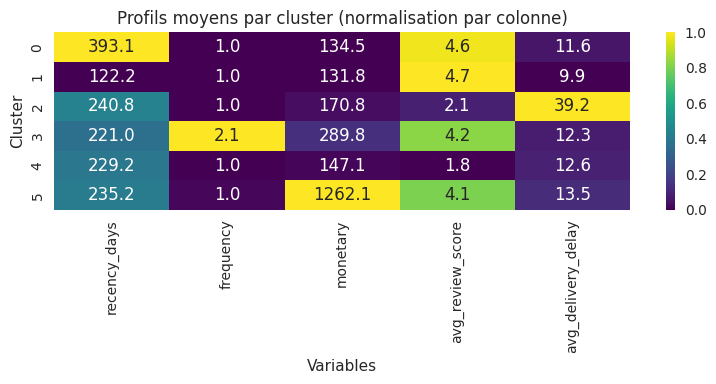

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # chez toi tu peux, moi pas ;)

cols_heatmap = [
    "recency_days",
    "frequency",
    "monetary",
    "avg_review_score",
    "avg_delivery_delay",
]

data_real = summary_k6[cols_heatmap]

# Normalisation min-max par colonne (pour les couleurs seulement)
data_norm = (data_real - data_real.min()) / (data_real.max() - data_real.min())

plt.figure(figsize=(8, 4))

ax = sns.heatmap(
    data_norm,
    annot=data_real.round(1),   # on affiche les VRAIES valeurs
    fmt=".1f",
    cmap="viridis",
    cbar=True,
)

ax.set_title("Profils moyens par cluster (normalisation par colonne)")
ax.set_xlabel("Variables")
ax.set_ylabel("Cluster")

plt.tight_layout()
plt.show()


In [ ]:
# Modèle final K=3 pour la segmentation "macro"
final_labels_k3 = km3.labels_
seg_k3 = rfm_business.copy()
seg_k3["cluster"] = final_labels_k3
seg_k3.to_csv("./olist_customers_segments_k3.csv")
seg_k3.groupby("cluster")[["recency_days","frequency","monetary","avg_review_score","avg_delivery_delay"]].mean().round(2)

,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,
0,237.58,1.00,153.00,4.65,10.60
1,220.85,2.11,325.88,4.20,12.34
2,246.07,1.00,194.14,1.79,21.87


In [26]:
# Modèle final (KMeans k=3)
seg = rfm_business.copy()
seg["cluster"] = km3.labels_

n_total = len(seg)

summary_k3 = (
    seg
    .groupby("cluster")
    .agg(
        count=("cluster", "size"),
        recency_days=("recency_days", "mean"),
        frequency=("frequency", "mean"),
        monetary=("monetary", "mean"),
        avg_review_score=("avg_review_score", "mean"),
        avg_delivery_delay=("avg_delivery_delay", "mean"),
    )
)

summary_k3["percentage"] = (summary_k3["count"] / n_total * 100).round(2)

summary_k3 = summary_k3.round(
    {"recency_days": 2, "frequency": 2, "monetary": 2,
     "avg_review_score": 2, "avg_delivery_delay": 2}
)

# Ordre souhaité
cols = [
    "count",
    "percentage",
    "recency_days",
    "frequency",
    "monetary",
    "avg_review_score",
    "avg_delivery_delay"
]

summary_k3 = summary_k3[cols]
summary_k3

,count,percentage,recency_days,frequency,monetary,avg_review_score,avg_delivery_delay
cluster,,,,,,,
0,74668,79.98,237.58,1.00,153.00,4.65,10.60
1,2808,3.01,220.85,2.11,325.88,4.20,12.34
2,15882,17.01,246.07,1.00,194.14,1.79,21.87


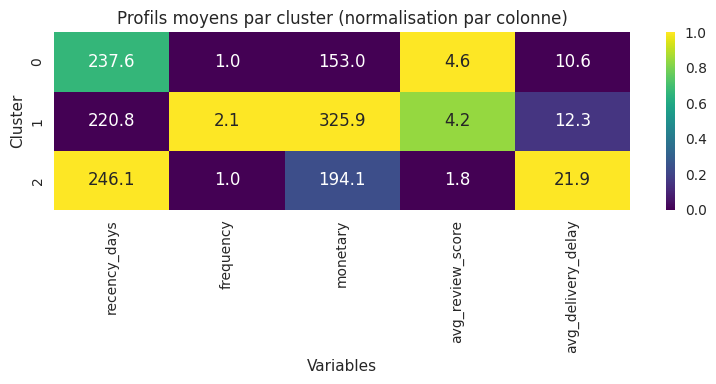

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cols_heatmap = [
    "recency_days",
    "frequency",
    "monetary",
    "avg_review_score",
    "avg_delivery_delay",
]

data_real = summary_k3[cols_heatmap]

# Normalisation min-max par colonne (pour les couleurs seulement)
data_norm = (data_real - data_real.min()) / (data_real.max() - data_real.min())

plt.figure(figsize=(8, 4))

ax = sns.heatmap(
    data_norm,
    annot=data_real.round(1),   
    fmt=".1f",
    cmap="viridis",
    cbar=True,
)

ax.set_title("Profils moyens par cluster (normalisation par colonne)")
ax.set_xlabel("Variables")
ax.set_ylabel("Cluster")

plt.tight_layout()
plt.show()

🎯 Cluster 0 – Acheteurs satisfaits, petits paniers, logistique correcte

Caractéristiques :

Récence moyenne (~238 jours)

Fréquence faible (1 achat)

Montant plutôt faible (153€)

Très bonne satisfaction (4.65)

Délai de livraison modéré (10.6 jours)

Interprétation :
➡️ Des clients isolés, qui achètent rarement et peu,
➡️ mais qui ont eu une très bonne expérience (review élevée + délai correct).
➡️ Pas à risque, mais pas très engagés non plus.

Nom possible :
“Satisfaits occasionnels”

🎯 Cluster 1 – Les bons clients / clients premium

Caractéristiques :

Récence la plus faible (~221 jours → ils sont revenus plus récemment)

Fréquence élevée (2.11 = >2 achats en moyenne)

Panier très élevé (326€ = le plus haut)

Satisfaction correcte (4.2)

Délai moyen (12.34)

Interprétation :
➡️ Ce sont clairement les meilleurs clients :

ils achètent plus souvent,

dépensent plus,

reviennent plus récemment,

ne sont pas hyper critiques.

➡️ C’est le segment le plus précieux en termes de valeur.

Nom possible :
“Clients fidèles à forte valeur”

🎯 Cluster 2 – Clients très insatisfaits et touchés par la logistique

Caractéristiques :

Récence élevée (~246 jours → ils ne reviennent plus)

Fréquence 1 (rare)

Panier moyen (194€)

Review catastrophique : 1.79

Délai très long : 21.87 jours (!!)

Interprétation forte (et justifiée) :
➡️ Ce cluster représente des clients qui ont eu une mauvaise expérience :

délai très long

note extrêmement basse
➡️ et qui n’ont jamais racheté depuis.

Clairement, c’est le segment de :

clients insatisfaits / churnés,

perdus suite à la qualité de service.

Nom possible :
“Clients insatisfaits + problèmes logistiques”

## Bilan
Les 3 clusters obtenus reflètent non pas des profils RFM classiques, mais 3 comportements centrés sur la satisfaction client :

(1) des acheteurs occasionnels satisfaits,

(2) des clients fidèles et à forte valeur,

(3) des clients insatisfaits ayant subi des délais très longs et n’ayant pas racheté.

Cet équilibre entre fréquence, montant, avis et délai donne une typologie comportementale claire et exploitable.

In [25]:
# Export du modèle final
joblib.dump(km3, "../models/kmeans_model_k3.joblib")

['../models/kmeans_model_k3.joblib']